In [2]:
# init settings
import os
import sys
pwd = os.getcwd()
sys.path.append(os.path.join(pwd, '..', '..'))

from server.utils import load_config
from server import db
from sqlalchemy.orm import sessionmaker
import json

conf_dir = os.path.abspath(os.path.join(pwd, '..', '..', 'config', 'base.yaml'))
config = load_config(conf_dir)

engine = db.sync_engine(config['postgres'])
Session = sessionmaker(bind=engine)
session = Session()

In [26]:
# Query data

from sqlalchemy.orm.exc import NoResultFound
import sqlalchemy as sa


start_date_filter = '2017-04-01 18:00'
end_date_filter = '2017-04-03 23:00'

pair = 'btc_usd'
cursor = session.query(db.order).filter(
    (db.order.c.extra['is_finished'].astext == '0')
    & (db.order.c.pair == pair)
    & (db.order.c.pub_date > start_date_filter)
    & (db.order.c.pub_date < end_date_filter)
).order_by(db.order.c.pub_date)

rate = session.query(db.history).filter(
    (db.history.c.pub_date > start_date_filter)
    & (db.history.c.pub_date < end_date_filter)
    & (db.history.c.pair == pair)
    & (sa.sql.func.random() < 0.01)
).order_by(db.history.c.pub_date)

def as_dict(row):
    item = row._asdict().copy()
    item['api'] = json.loads(item['api'])
    return item

def iter_tail(item, tail):
    try:
        next_steps = session.query(db.order).filter(
            ((db.order.c.extra['next'].astext == str(item['id']))
            | (db.order.c.extra['merged'].astext == str(item['id']))) 
            & (db.order.c.pub_date > start_date_filter)
            & (db.order.c.pub_date < end_date_filter)
        )
    except NoResultFound:
        return tail
        
    for next_step in next_steps:
        next_step_item = as_dict(next_step)
        tail.append(next_step_item)
        iter_tail(next_step_item, tail)
    return tail

In [27]:
# Data proccesing

thread_list = []
for order in cursor:
    item = as_dict(order)
    tail = [item]
    iter_tail(item, tail)
    thread_list.append(tail)
    
rate_dict = {
    'date': [],
    'sell_price': [],
    'buy_price': []
}
for rate_info in rate:
    resp = json.loads(rate_info.resp)
    rate_dict['date'].append(rate_info.pub_date)
    rate_dict['buy_price'].append(resp['asks'][0][0])
    rate_dict['sell_price'].append(resp['bids'][0][0])
print(len(rate_dict['date']), len(thread_list))

414 9


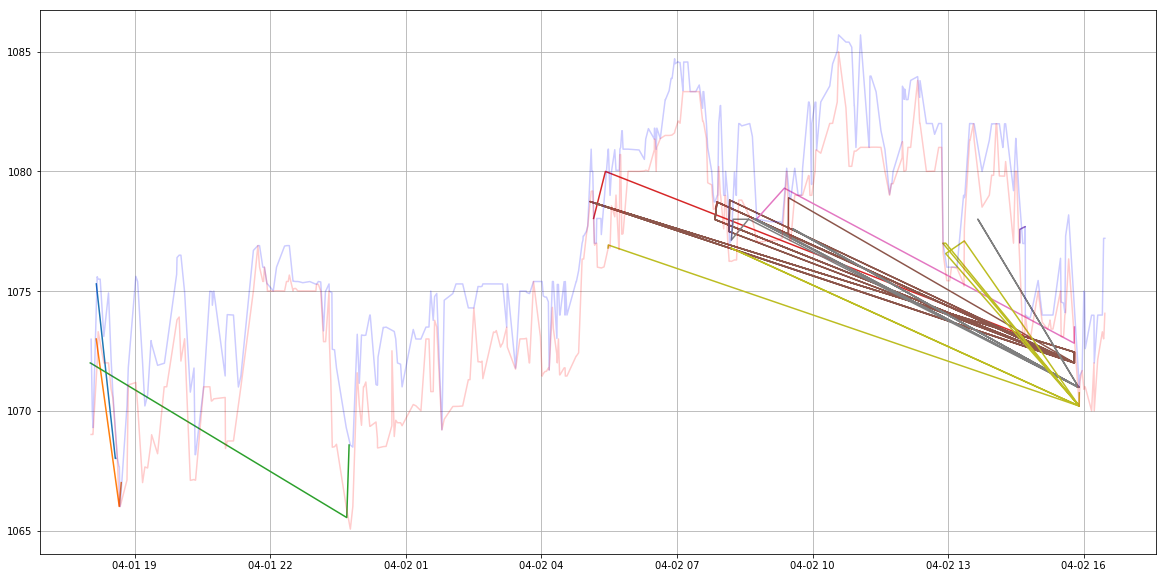

In [28]:
# Data visualisite

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.grid(True)
for thread in thread_list:
    plt.plot(
        list(map(lambda i: i['pub_date'], thread)), 
        list(map(lambda i: i['price'], thread))
    )

plt.plot(rate_dict['date'], rate_dict['buy_price'], alpha=0.2, color='blue')
plt.plot(rate_dict['date'], rate_dict['sell_price'], alpha=0.2, color='red')
plt.show()